# Flax Study

## 1. A simple example - CNN

refer:  https://github.com/google/flax/tree/main/examples/mnist

https://flax.readthedocs.io/en/latest/getting_started.html

### CNN Training


1. definition

In [15]:
from flax import linen as nn

class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

   2. invoke example

In [16]:
rng = jax.random.PRNGKey(0)

def create_train_state(rng, config):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.sgd(config.learning_rate, config.momentum)
  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx) # 包含CNN参数 和 优化参数

# rng, init_rng = jax.random.split(rng)
# state = create_train_state(init_rng, config) 

@jax.jit
def apply_model(state, images, labels):
  """Computes gradients, loss and accuracy for a single batch."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, images) # <- CNN计算
    one_hot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True) # add grad calculation
  (loss, logits), grads = grad_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return grads, loss, accuracy

@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)  # apply grads to model state

# grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
# state = update_model(state, grads)

### Working flows

#### 0. Dataset


In [18]:
import tensorflow_datasets as tfds

def get_datasets():
  """Load MNIST train and test datasets into memory."""
  ds_builder = tfds.builder('mnist')
  ds_builder.download_and_prepare()
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 255.
  test_ds['image'] = jnp.float32(test_ds['image']) / 255.
  return train_ds, test_ds

# train_ds, test_ds = get_datasets()
# train_ds_size = len(train_ds['image'])
# steps_per_epoch = train_ds_size // batch_size

# key, input_rng = jax.random.split(key)
# perms = jax.random.permutation(input_rng, len(train_ds['image']))
# perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
# perms = perms.reshape((steps_per_epoch, batch_size))

## one Epoch
# batch_images = train_ds['image'][perm, ...]
# batch_labels = train_ds['label'][perm, ...]

#### 1. config

In [13]:
%load_ext autoreload
%autoreload 2
from myconfigs import default as config_lib
config = config_lib.get_config()
config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


batch_size: 128
learning_rate: 0.1
momentum: 0.9
num_epochs: 10

#### 2. Logger & tensorboard

In [19]:
from absl import logging
from flax.metrics import tensorboard

logging.set_verbosity(logging.INFO)
logging.info("helloworld!")
# logging.info(
#     'epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, test_loss: %.4f, test_accuracy: %.2f'
#     % (epoch, train_loss, train_accuracy * 100, test_loss,
#         test_accuracy * 100))
workdir = "./logger"
summary_writer = tensorboard.SummaryWriter(workdir)
summary_writer.hparams(dict(config))

# epoch = 1
# train_loss = 10.1
# summary_writer.scalar('train_loss', train_loss, epoch)

# summary_writer.scalar('train_loss', train_loss, epoch)
# summary_writer.scalar('train_accuracy', train_accuracy, epoch)
# summary_writer.scalar('test_loss', test_loss, epoch)
# summary_writer.scalar('test_accuracy', test_accuracy, epoch)

# summary_writer.flush()

INFO:absl:helloworld!


#### 3. training

In [ ]:
def train_and_evaluate(config: ml_collections.ConfigDict,
                       workdir: str) -> train_state.TrainState:
  """Execute model training and evaluation loop.

  Args:
    config: Hyperparameter configuration for training and evaluation.
    workdir: Directory where the tensorboard summaries are written to.

  Returns:
    The train state (which includes the `.params`).
  """
  train_ds, test_ds = get_datasets()
  rng = jax.random.PRNGKey(0)

  summary_writer = tensorboard.SummaryWriter(workdir)
  summary_writer.hparams(dict(config))

  rng, init_rng = jax.random.split(rng)
  state = create_train_state(init_rng, config)

  for epoch in range(1, config.num_epochs + 1):
    rng, input_rng = jax.random.split(rng)
    state, train_loss, train_accuracy = train_epoch(state, train_ds,
                                                    config.batch_size,
                                                    input_rng)
    _, test_loss, test_accuracy = apply_model(state, test_ds['image'],
                                              test_ds['label'])

    logging.info(
        'epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, test_loss: %.4f, test_accuracy: %.2f'
        % (epoch, train_loss, train_accuracy * 100, test_loss,
           test_accuracy * 100))

    summary_writer.scalar('train_loss', train_loss, epoch)
    summary_writer.scalar('train_accuracy', train_accuracy, epoch)
    summary_writer.scalar('test_loss', test_loss, epoch)
    summary_writer.scalar('test_accuracy', test_accuracy, epoch)

  summary_writer.flush()
  return state


#### 4. Plot



INFO:absl:Load dataset info from ~/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (~/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split train, from ~/tensorflow_datasets/mnist/3.0.1
INFO:absl:Constructing tf.data.Dataset mnist for split test, from ~/tensorflow_datasets/mnist/3.0.1


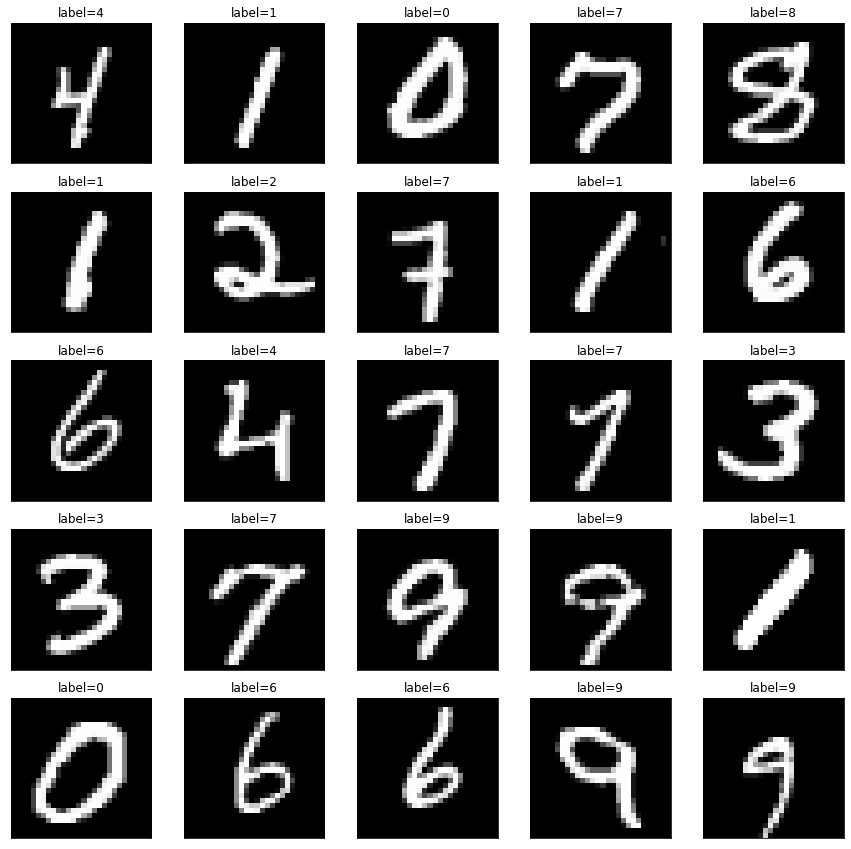

In [27]:
import numpy as np
from matplotlib import pyplot as plt
import mycode.train

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[..., 0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

train_ds, test_ds = train.get_datasets()
show_img_grid(
    [train_ds['image'][idx] for idx in range(25)],
    [f'label={train_ds["label"][idx]}' for idx in range(25)],
)

## 2. DMs - MNIST